


# Imágenes médicas - DICOM


## El standard DICOM

Para facilitar la intercomunicación entre distintas modalidades de diagnóstico por imágenes, se creó en 1993 el formato **DICOM** (*Digital Imaging and Communications in Medicine*). 
Este es un standard que define cómo guardar la información de una imagen, series de imágenes e incluso videos (*cines*), junto con datos relevantes de la misma, datos del paciente, del centro médico, de la modalidad específica de diagnóstico, etc.

La definición del standard es extensísima (pueden consultarla en [https://www.dicomstandard.org/current](https://www.dicomstandard.org/current)), dado que incluye un enorme abanico de posibles tipos de datos. 



Esencialmente, un archivo DICOM está estructurado en una lista de *TAGS* que se componen de la siguiente manera:

- Dos números hexadecimales (denominados **Grupo** y **Elemento**) que identifican el atributo de la imagen. Cada atributo tiene un nombre asociado, que es el que se utiliza generalmente para acceder al mismo. Por ejemplo

        (0008, 0060) Modality 
corresponde al grupo 0008, elemento 0006 que describe el atributo Modalidad de la imagen.

- Dos letras (**Value Representation**) que indican el tipo de dato que se está guardando en el tag, por ejemplo
    - 'SH' para *short strings* (hasta 16 caracteres)
    - 'US' para *enteros sin signo* (enteros mayores o iguales que cero, usando 2 bytes)
    - 'SQ' para secuencias de otros tags
    - [y otros más](http://dicom.nema.org/dicom/2013/output/chtml/part05/sect_6.2.html)
- El valor específico del atributo en sí.

Entonces, un tag completo sería

    (0008, 0080) Institution Name                    LO: 'INTECNUS'

   

> Recomendamos usar la página [https://dicom.innolitics.com/ciods](https://dicom.innolitics.com/ciods) para explorar los tag DICOM, dado que la página del standard es compleja para buscar información

Afortunadamente, la gran mayoría de los lenguajes provee de bibliotecas para trabajar con archivos DICOM. Python no es una excepción, y usa el módulo `pydicom`. 

## Instalando `pydicom`

Desafortunadamente, `pydicom` no viene instalado por defecto en Anaconda. Veamos cómo instalarlo.

1. Correr la línea de comando de miniconda.
2. En la línea de comando, 

        conda install -c conda-forge pydicom



## Usando `pydicom`

Una vez instalado `pydicom`, es posible usarlo como un módulo cualquiera. La documentación está acá: [https://pydicom.github.io/pydicom/stable/index.html](https://pydicom.github.io/pydicom/stable/index.html)

> Es importante mencionar que, además de poder acceder a todos los tags DICOM de un archivo, `pydicom` además guarda información del archivo en sus propias variables, para facilitar el acceso a las mismas. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom

#
#    pydicom provee algunos datos de ejemplo, que se pueden importar así:
#
# from pydicom.data import get_testdata_files

### Abrir un archivo DICOM

In [2]:
DCM = pydicom.dcmread(r'../Assets/CT/IM-0001-0200-0001.dcm')

FileNotFoundError: [Errno 2] No such file or directory: '../Assets/CT/IM-0001-0200-0001.dcm'

In [3]:
type(DCM)

pydicom.dataset.FileDataset

In [6]:
DCM

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20191106'
(0008, 0013) Instance Creation Time              TM: '164949'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.290.3.1225403042.932.1573045470.721.200
(0008, 0020) Study Date                          DA: '20191106'
(0008, 0021) Series Date                         DA: '20191106'
(0008, 0022) Acquisition Date                    DA: '20191106'
(0008, 0023) Content Date                        DA: '20191106'
(0008, 0030) Study Time                          TM: '164219'
(0008, 0031) Series Time                         TM: '164539'
(0008, 0032) Acquisition Time                    TM: '164650.808161'
(0008, 0033) Content Time                        TM: '164949'
(0008, 0050) Accession Number  

Para acceder a cada uno de los atributos del archivo DICOM se utiliza el nombre del atributo

In [7]:
DCM.PatientName

'PET CT INTECNUS'

In [8]:
DCM.StudyDescription

'PET CUERPO COMPLETO-'

In [10]:
DCM.ProtocolName

'10.1 PET/CT FDG + TORAX'

Pero también tengo la información desde el tag, usando el grupo y elemento en representación hexadecimal:

In [11]:
print("Tag  : ",DCM[0x0018,0x1030].tag)
print("VR   : ",DCM[0x0018,0x1030].VR)
print("valor: ",DCM[0x0018,0x1030].value)

Tag  :  (0018, 1030)
VR   :  LO
valor:  10.1 PET/CT FDG + TORAX


#### *Para acceder a CAMPOS PRIVADOS debo hacerlo por el TAG*
Un campo privado se encuentran definidos por el fabricante y no estan en el diccionario del estándar. Sin embargo, se encuentran perfectamente detallados en los respectivos **dicom conformance statement** de cada equipo.

In [12]:
DCM[0x0009, 0x1004]

(0009, 1004) [Product id]                        SH: 'Discovery 710'

In [13]:
print(DCM[0x0009, 0x1004].tag,
      DCM[0x0009, 0x1004].VR,
      DCM[0x0009, 0x1004].value, sep='\n')

(0009, 1004)
SH
Discovery 710


### Las imágenes DICOM

Las imágenes propiamente dichas se encuentran guardadas como un array en el atributo **PIXEL DATA** 

In [14]:
print(DCM[0x7fe0, 0x0010])
print(type(DCM.PixelData))
print(DCM.PixelData[0:11])

(7fe0, 0010) Pixel Data                          OW: Array of 524288 elements
<class 'bytes'>
b'0\xf80\xf80\xf80\xf80\xf80'


Sin embargo, este atributo tiene como *Value Representation* a 'OW', (*Other Word String*) que no parece ser muy amigable...

Por eso, `pydicom` guarda la imagen en la variable `pixel_array`, que es un array de `numpy`:

In [15]:
print(type(DCM.pixel_array))
print("Tamaño de la imagen:",DCM.pixel_array.shape)

<class 'numpy.ndarray'>
Tamaño de la imagen: (512, 512)


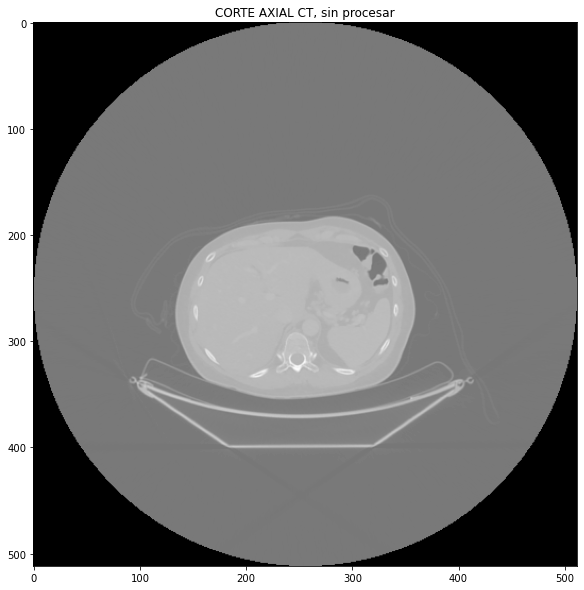

In [16]:
fig_1 = plt.figure(1, figsize=[10,10])
img1 = fig_1.add_subplot(111)
img1.imshow(DCM.pixel_array, cmap='gray')
img1.set_title('CORTE AXIAL CT, sin procesar')
plt.show()

In [63]:
print(DCM.pixel_array)

[[-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 ...
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]]


## Ajustando la imagen


### Obteniendo HUs

Cada pixel de una imagen de CT corresponde a un determinado valor de unidades de Hounsfield. Sin embargo, los valores que se guardan en los archivos no corresponden directamente a los valores de HU, sino a una versión rescaleada (esto se debe básicamente a las limitaciones que impone el formato DICOM al tipo de dato a usar). Por eso, para obtener HU, es necesario aplicar la siguiente transformación lineal:

$$
f_t(x,y) = \texttt{DCM.RescaleSlope} \times f_{orig}(x,y)  + \texttt{DCM.RescaleIntercept}
$$


In [14]:
print(DCM.RescaleType)
print(DCM.RescaleSlope)
print(DCM.RescaleIntercept)

HU
1
-1024


In [17]:
imagen = DCM.pixel_array * DCM.RescaleSlope + DCM.RescaleIntercept
print(imagen)

[[-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 ...
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]]


In [19]:
print(imagen[50,256])
print(np.min(imagen))
print(np.max(imagen))
imagen2 = np.clip(imagen, -1000,np.max(imagen))
print(imagen2)

-1000.0
-3024.0
1251.0
[[-1000. -1000. -1000. ... -1000. -1000. -1000.]
 [-1000. -1000. -1000. ... -1000. -1000. -1000.]
 [-1000. -1000. -1000. ... -1000. -1000. -1000.]
 ...
 [-1000. -1000. -1000. ... -1000. -1000. -1000.]
 [-1000. -1000. -1000. ... -1000. -1000. -1000.]
 [-1000. -1000. -1000. ... -1000. -1000. -1000.]]


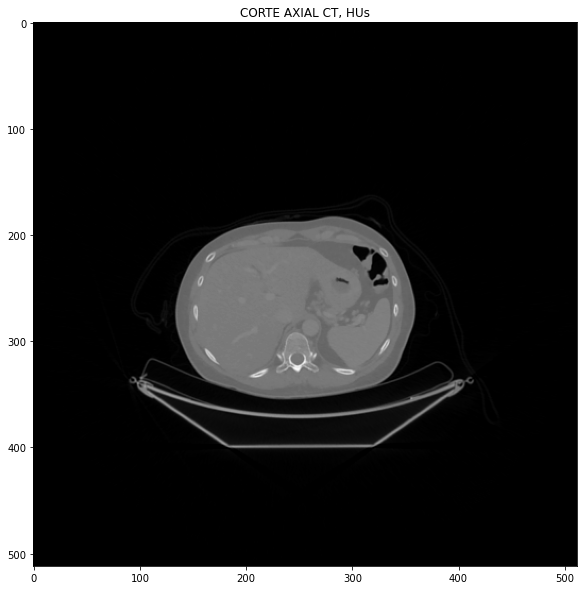

In [20]:
fig_1 = plt.figure(1, figsize=[10,10])
img1 = fig_1.add_subplot(111)
img1.imshow(imagen2, cmap='gray')
img1.set_title('CORTE AXIAL CT, HUs')
plt.show()

### Window and Level

El proceso de *Windowing* ( o *grey-level mapping, contrast stretching, histogram modification, contrast enhancement, LUT*, etc.) consiste en manipular las componentes de la imagen de forma tal que se puedan realzar ciertas estructuras particulares. El brillo de la imagen se ajusta a partir del *Window Level*, mientras que el contraste se ajusta a partir del *Window Width*.

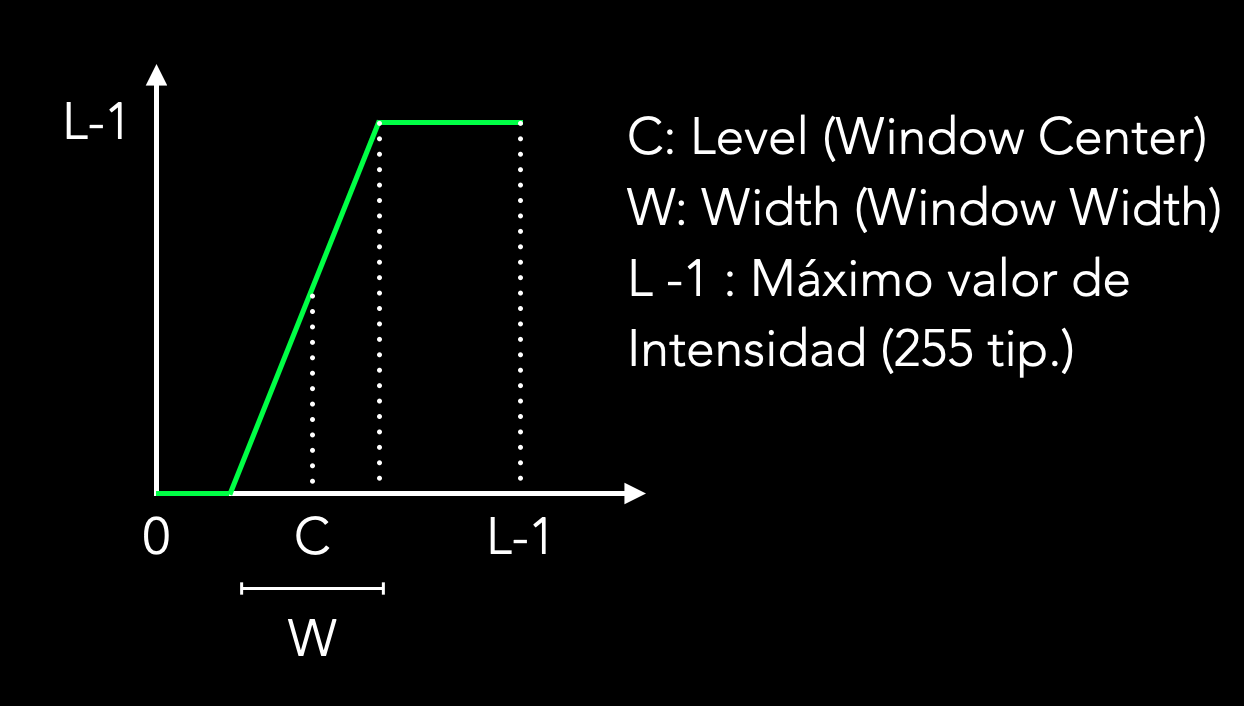

Cada DICOM puede proveer un ancho y centro de ventana que viene desde el equipo de adquisición de imágenes:

In [71]:
print(DCM.WindowCenter)
print(DCM.WindowWidth)

40
400


> Recordemos que el valor de los pixeles en el monitor van de 0 a 255

Típicamente si definimos

\begin{align}
c &= \texttt{DCM.WindowCenter} \\
w &= \texttt{DCM.WindowWidth}
\end{align}

Entonces, la imagen transformada se obtiene como:

\begin{align}
f_t(x,y) &= 0 &\textrm{si} \qquad f(x,y) < c - w /2 \\
f_t(x,y) &= 255  &\textrm{si} \qquad f(x,y) > c + w /2 \\
f_t(x,y) &= (f(x,y) - c)  \times 255/w   &\textrm{en otro caso} 
\end{align}



In [18]:
print('El centro de ventana es: ', DCM.WindowCenter, '\nEl ancho de ventana es: ', DCM.WindowWidth)

El centro de ventana es:  40 
El ancho de ventana es:  400


Veamos si podemos hacer esto sin tener que generar otra imagen transformada. Para eso, veamos los parámetros opcionales de `plt.imshow`:

In [21]:
plt.imshow?

Es decir que si pasamos el máximo y el mínimo de la ventana, ya obtendríamos el resultado esperado:

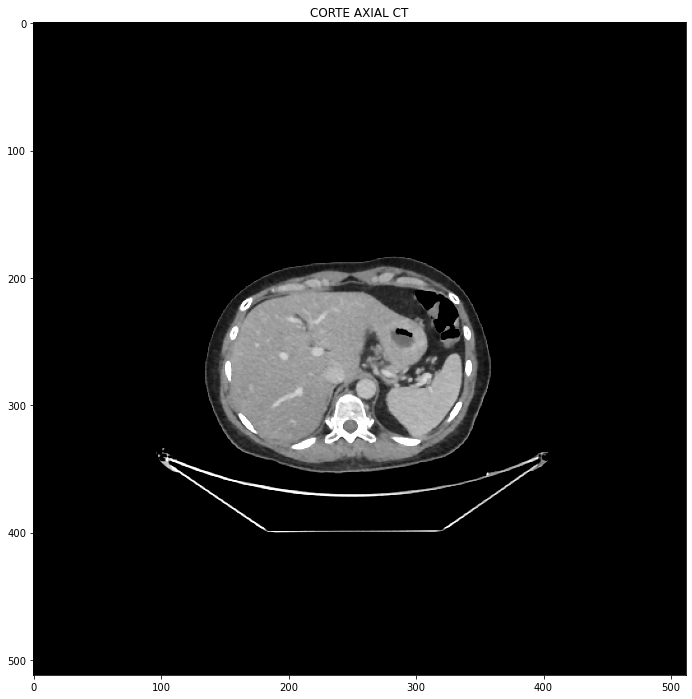

In [22]:
c = 40
w = 400
ventmax = c + w/2
ventmin = c - w/2

fig_1 = plt.figure(1, figsize=[12,12])
img1 = fig_1.add_subplot(111)
img1.imshow(imagen, cmap='gray', vmin=ventmin, vmax=ventmax)
img1.set_title('CORTE AXIAL CT')
plt.show()

### Manipulando la imagen

Finalmente, podemos manipular la imagen a voluntad, dado que es un array de `numpy`. Por ejemplo, podemos reemplazar los puntos de la matriz por otros valores

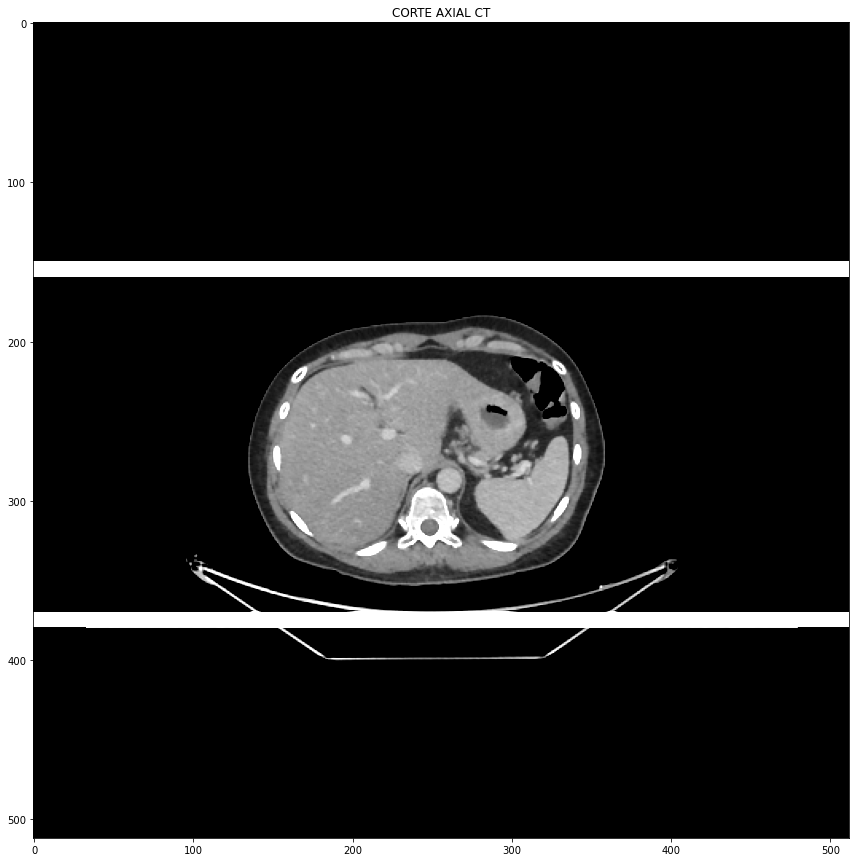

In [23]:
imagen2 = imagen.copy()
imagen2[150:160,:] = 1000
imagen2[370:380,:] = 1000


fig_1 = plt.figure(1, figsize=[15,15])
img1 = fig_1.add_subplot(111)
img1.imshow(imagen2, cmap='gray', vmin=ventmin, vmax=ventmax)
img1.set_title('CORTE AXIAL CT')
plt.show()

O reemplazar ciertos puntos de acuerdo a una condición particular:

In [24]:
imagen2 = imagen.copy()
imagen2[imagen2 < -800] = 1000

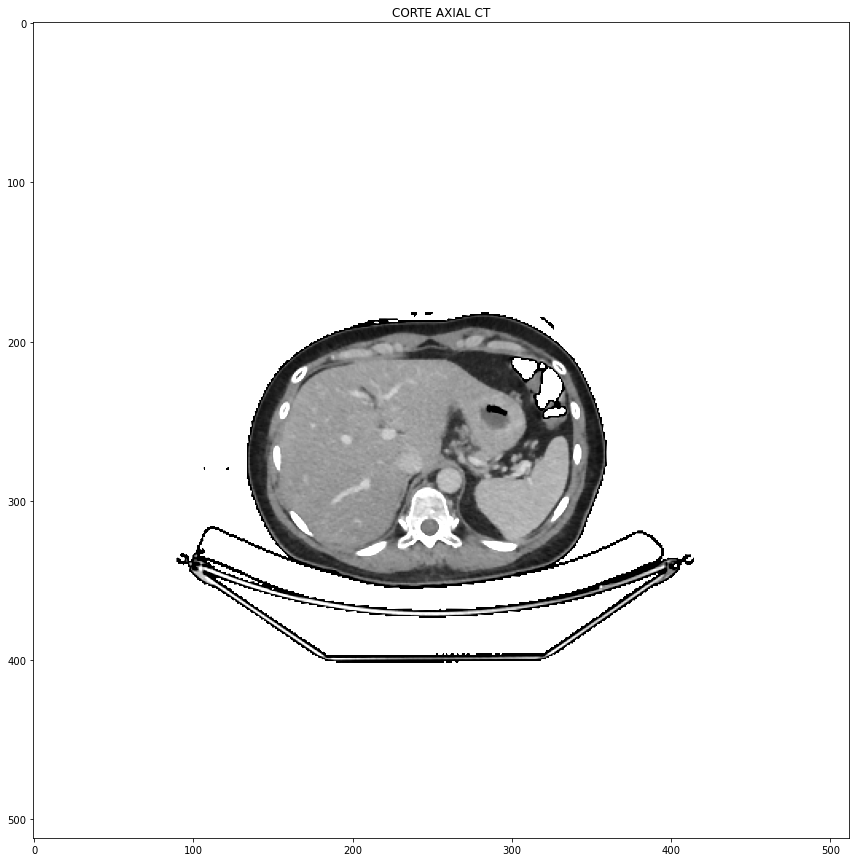

In [25]:
fig_1 = plt.figure(1, figsize=[15,15])
img1 = fig_1.add_subplot(111)
img1.imshow(imagen2, cmap='gray', vmin=ventmin, vmax=ventmax)
img1.set_title('CORTE AXIAL CT')
plt.show()

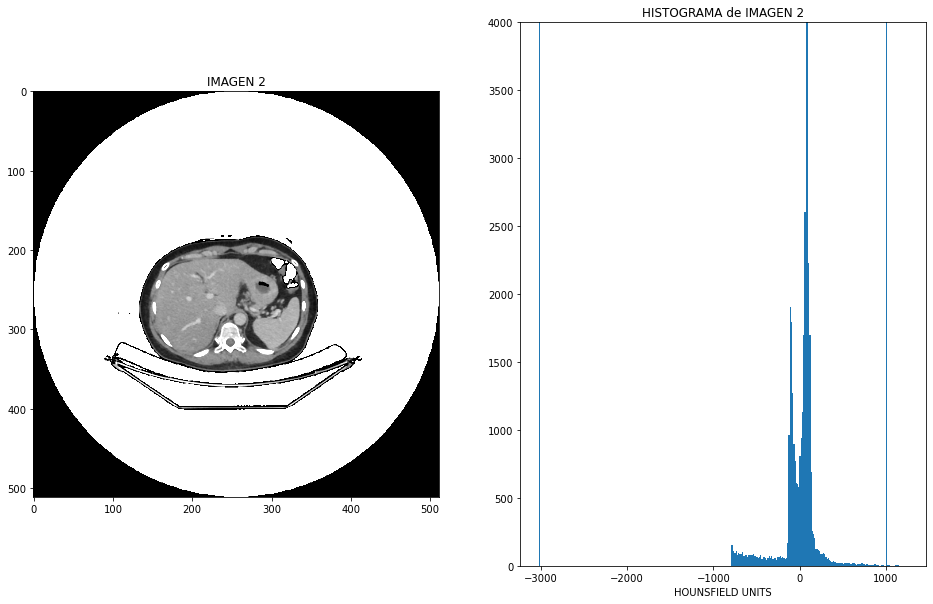

El FOV del CT del PET es de:  700.000256 mm


In [26]:
imagen2 = imagen.copy()
imagen2[(imagen2<-800) & (imagen2>-1100)] = 1000

fig5, g = plt.subplots(1, 2, figsize=[16,10])
g[0].imshow(imagen2, cmap = 'gray', vmin=ventmin, vmax=ventmax)
g[0].set_title('IMAGEN 2')

g[1].set_title('HISTOGRAMA de IMAGEN 2')
g[1].hist(imagen2.ravel(), bins=300) #ravel devuelve un vector 1D con todos los elementosde la matrix.
g[1].set_xlabel('HOUNSFIELD UNITS')
g[1].set_xlim()
g[1].set_ylim([0, 4000])

plt.show()

print('El FOV del CT del PET es de: ', imagen2.shape[0] * DCM.PixelSpacing[0], 'mm')

#### Ventanas de visualización típicas en CT

- Cabeza y cuello
    - cerebro w:80 c:40
    - subdural w:130-300 c:50-100
    - acv w:8 c:32 / w:40 c:40
    - hueso w:2800 c:600
    - Tejido blando: w:350–400 c:20–60
    
- Pecho
    - Pulmones w:1500 c:-600
    - Mediastino w:350 c:50
    
- Abdomen
    - Tejido blando w:400 c:50
    - Hígado w:150 c:30

- Columna
    - Tejido blando w:250 c:50
    - Hueso w:1800 c:400
